Import 

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt 
from fastmri.models.varnet import VarNet

from fastmri_compare.unet_C.unet_torch_training_script import filename_to_image_and_kspace
from fastmri_compare.varnetC.varnet_trainning_script import get_masked_kspace, BonneShape

ModuleNotFoundError: No module named 'fastmri_compare.unet_C.unet_torch_training_script'

Charger le model : Varnet 

In [ ]:
model = VarNet(
        num_cascades=2,
        sens_chans=4,
        sens_pools=2,
        chans=32,
        pools=2,
        mask_center=True,
    )

Recupere celui qui a ete entraine sur une grande quantité de donnée 

In [ ]:
model.load_state_dict(torch.load("/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/examples/fastmri_varnet_model.pth"))
model.eval()

VarNet(
  (sens_net): SensitivityModel(
    (norm_unet): NormUnet(
      (unet): Unet(
        (down_sample_layers): ModuleList(
          (0): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (2): LeakyReLU(negative_slope=0.2, inplace=True)
              (3): Dropout2d(p=0.0, inplace=False)
              (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (5): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (6): LeakyReLU(negative_slope=0.2, inplace=True)
              (7): Dropout2d(p=0.0, inplace=False)
            )
          )
          (1): ConvBlock(
            (layers): Sequential(
              (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

Prétraiter vos nouvelles données:
importation et préparation 
Prend en argument le path 
Recupere les données Kspace , FT pour avoir l'image , VCR pour en faire un Single coil

In [ ]:
filepath = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/dataset/file_brain_AXT1POST_201_6002780.h5"
image, kspace = filename_to_image_and_kspace(filepath)

Creation du mask :
Choix de la function (default "random"), chaque batch a un mask different 

In [ ]:
masked_kspace, mask = get_masked_kspace(kspace)

Pour Varnet , la shape doit etre ( Batch, Coils, Height, Weight, Complex)

In [ ]:
masked_kspace = BonneShape(image, masked_kspace)

torch.Size([16, 1, 640, 320, 2])


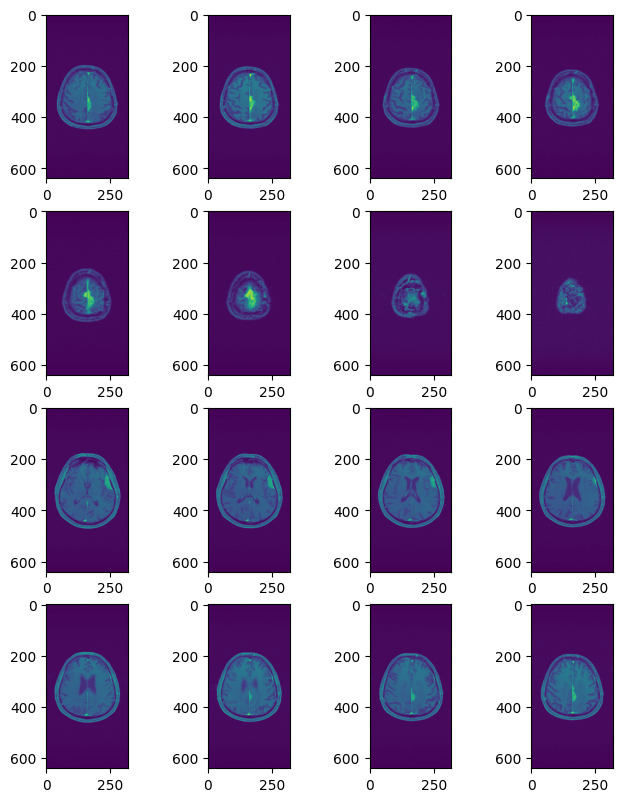

In [ ]:
print(masked_kspace.shape)
plt.figure(figsize=(8,20))
for i in range(masked_kspace.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(np.abs(torch.fft.fft2(masked_kspace[i,0,:,:,0] + (1j*masked_kspace[i,0,:,:,1]))))

Effectuer des prédictions

In [ ]:
with torch.no_grad():
    output = model(masked_kspace, mask.byte())
    output = torch.fft.fftshift(output)

/volatile/Lena/Environments/fastmri/lib/python3.10/site-packages/fastmri/models/varnet.py:318: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.dc_weight


Afficher mes predictions

torch.Size([16, 640, 320])


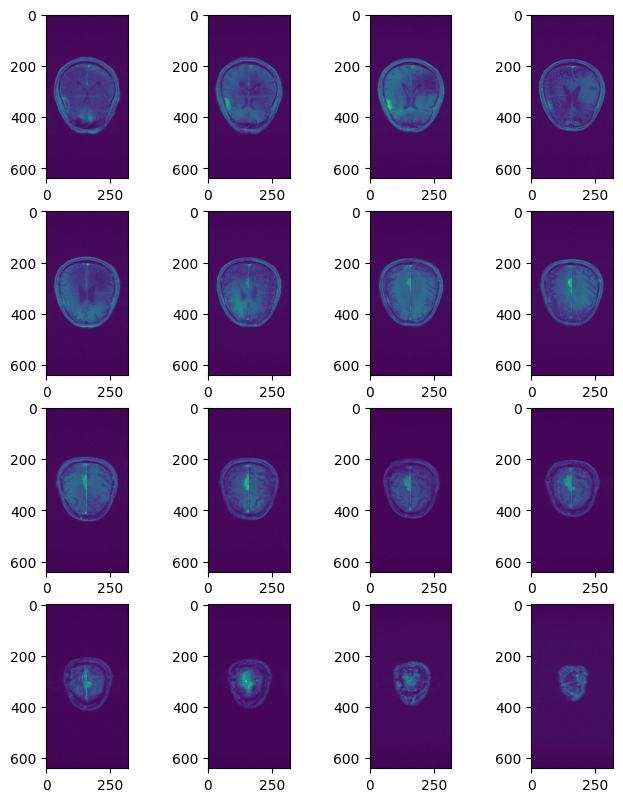

In [ ]:
print(output.shape)
plt.figure(figsize=(8,20))
for i in range(output.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(output[i,:,:])